<h1>Raster Fairy - optional random swapping optimization</h1>
<p>Version 1.02<br/>Author: Mario Klingemann | @Quasimondo</p>
<p>Whilst Raster Fairy is very flexible with the variety of arrangements it can generate and also shows good performance even with big datasets it usually does not find the optimum arrangement that matrix-based methods like the Hungarian Algorithm can give you. Matrix-based methods on the other hand might be limited to square grids, can suffer from numerical issues and memory issues with big sets.</p>
<p>This demo uses several techniques by Kyle McDonald who's <a href="https://github.com/kylemcdonald/CloudToGrid">CloudToGrid</a> repository you should check out if you are looking for a good Hungarian based solution</p>
<p>As an optional step Raster Fairy offers a SwapOptimizer class which uses an evolutionary process to improve the arrangement iteratively. It can even be used standalone and given enough iterations will also converge on a near-optimal arrangement starting from a random arrangement.</p>
<p>In this demo I will show you how to use the SwapOptimizer class. As usual we start by creating an example dataset consisting of random RGB points and calculate a 2D t-sne embedding from it.</p>

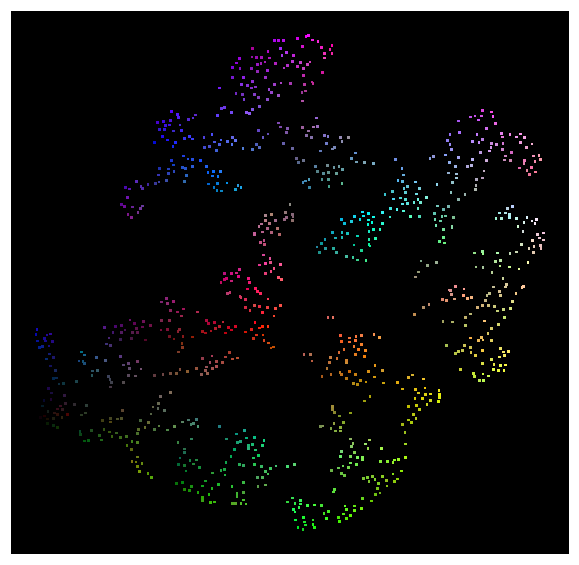

In [2]:
# just some basic setup for the purpose of this demo:
%matplotlib inline  
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
from sklearn.manifold import TSNE

# generate a set of 1024 random 3D points
totalDataPoints = 1024 
dataPoints = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints,3))

# create a t-sne embedding in 2D
model = TSNE(n_components=2, perplexity=30, random_state=0,metric='sqeuclidean')
xy = model.fit_transform(dataPoints) 


fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(xy[:,0],xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()


Now we use Raster Fairy to generate a square grid from the cloud. Usually Raster Fairy will try to generate all possible permuations of arrangements for a given number of data points. When a number has many prime factors this is problematic, for example 1024 has the prime factors 2x2x2x2x2x2x2x2x2x2 which results in 10! = 3.628.800 possible permutations. So what Raster Fairy does in a case like this is to group all identical prime factors and only create permutations for the groups. This process might be improved in the future.

not enough memory for amount of possible permutations, creating grouped set
[(32, 32), (16, 64), (8, 128), (4, 256), (2, 512), (1, 1024)]


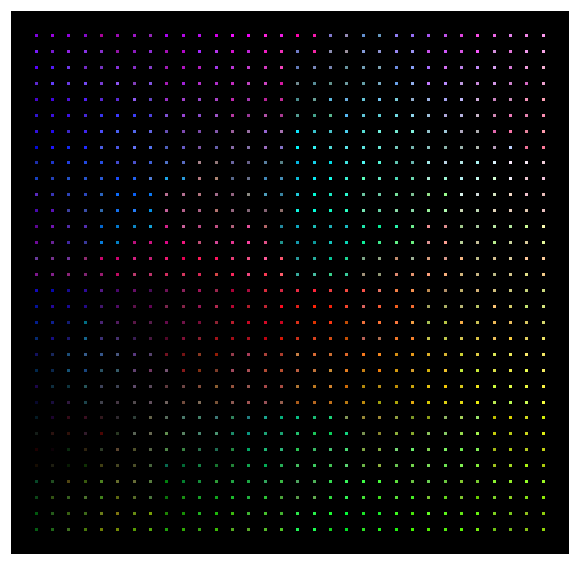

In [3]:
import rasterfairy

arrangements = rasterfairy.getRectArrangements(totalDataPoints)

print arrangements
grid_xy,(width,height) = rasterfairy.transformPointCloud2D(xy,target=arrangements[0])

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

This does not look too shabby, but the SwapOptimzier class can be used to further improve the result. It tries to optimize the arrangement so that the total travel distance of all original points to their final grid destination becomes minimal.

In [5]:
from rasterfairy import rfoptimizer

optimizer = rfoptimizer.SwapOptimizer()

#since we used an arrangement we get the width and height of the grid from there
width, height = arrangements[0]

#if you used a raster mask instead you'd take the width and height from its metadata like this:
#width = rasterMask['width']
#height = rasterMask['height']

iterations = 100000
swapTable = optimizer.optimize(xy, grid_xy,width,height,iterations)


Starting sum of distances 19.0703328418
80000 18.2950508428
81000 18.2930358973
82000 18.2818087119
83000 18.2796147745
84000 18.2759717437
85000 18.2756612732
86000 18.272942357
87000 18.2728537267
88000 18.2717677402
89000 18.2713318766
90000 18.2710884433
91000 18.2710884433
92000 18.2697576062
93000 18.2693935176
94000 18.2663792382
95000 18.2648151715
96000 18.2615778765
97000 18.2587832159
98000 18.2563957297
99000 18.2542690322
final distance sum: 18.2542690322
improvement: 0.81606380962


If you want to see how the found improvement looks you use the returned list of indices to get a newly ordered set of grid points from the originally returned grid:

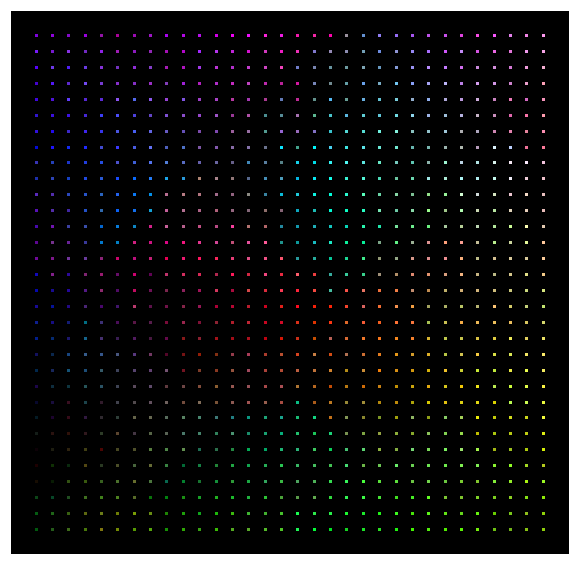

In [7]:
optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

You can see if the swapping results in any further improvements by watching the progress report. If the final improvement is bigger than 0.0 that usually means that further improvement is possible. To continue from the last state of optimization you can use the continueOptimization() method, note that if you called the optimize again with the same arguments it would restart from the original grid and not continue.

In [9]:
swapTable = optimizer.continueOptimization(100000)

optimized_xy = grid_xy[swapTable]

Starting sum of distances 18.1622642789
80000 18.1336642914
81000 18.1336642914
82000 18.1336642914
83000 18.1336642914
84000 18.1336642914
85000 18.1336642914
86000 18.1335128097
87000 18.1335128097
88000 18.1329015507
89000 18.1320562871
90000 18.1320562871
91000 18.1317431568
92000 18.1317431568
93000 18.1317431568
94000 18.1317431568
95000 18.1311884712
96000 18.1311884712
97000 18.1311884712
98000 18.1311884712
99000 18.1311884712
final distance sum: 18.1311884712
improvement: 0.0310758077536


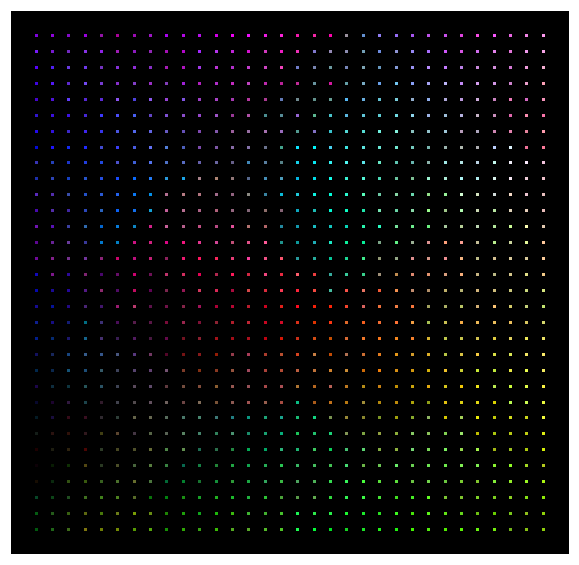

In [10]:
fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

At some point the improvements will usually stall and the arrangement has reached a point where it is very unlikely that the swapping will find a better solution. Still it is possible that the found result is just a local optimum. In order to get out of this optimum what is required is to stir up the arrangement a bit more, so it temporarily gets worse and then let the optimizer try to find a better solution than before. I've called this process "shaking" since you could see the grid like a play board with little balls and holes where every ball settles in a hole - and now imagine the stir up like picking up the board and giving it a bit of a shake or a whack :-).

This process is usually called "simulated annealing" and often results in small improvements. It's important though to give the optimizer enough iterations to recuperate from the disturbance. Otherwise, if it did not find a better solution in the given amount of iterations it will revert to the previously found best arrangement. Of course you can always try again and hope that the shaking happens at the right places.

In [12]:
swapTable = optimizer.continueOptimization(100000,shakeIterations=5)

optimized_xy = grid_xy[swapTable]


Starting sum of distances 18.1239206426
80000 18.1261128778
81000 18.1261128778
82000 18.1261128778
83000 18.1261128778
84000 18.1261128778
85000 18.1261128778
86000 18.1261128778
87000 18.1261128778
88000 18.1261128778
89000 18.1249177498
90000 18.1249177498
91000 18.1249177498
92000 18.1249177498
93000 18.1249177498
94000 18.1249177498
95000 18.1249177498
96000 18.1249177498
97000 18.1249177498
98000 18.1249177498
99000 18.1249177498
final distance sum: 18.1246787426
improvement: -0.000758099922741
reverting to initial swap table


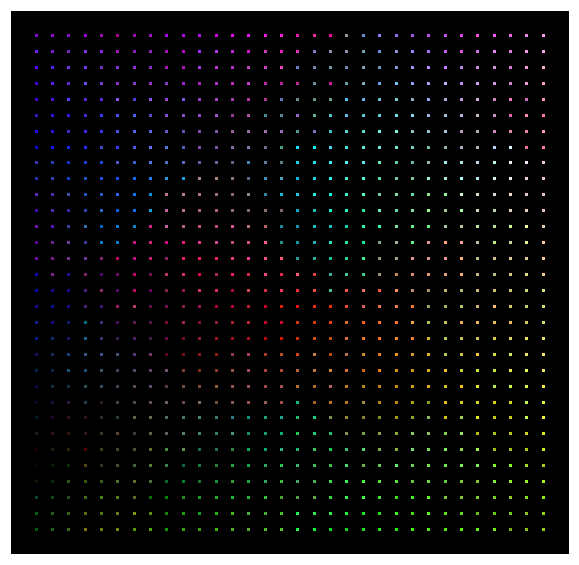

In [13]:

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

To see what how the original cloud maps to the grid and what kind of changes the swap optimizer has made you can use these debug views:

total iterations: 500000


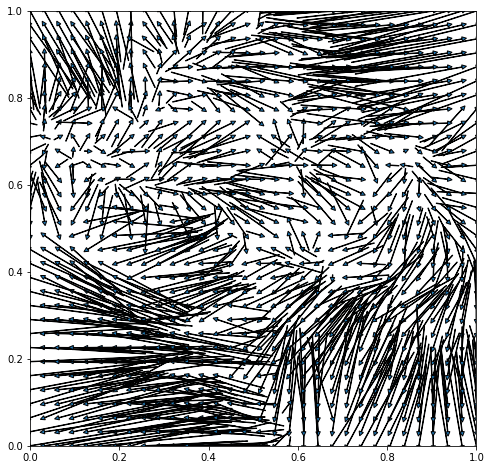

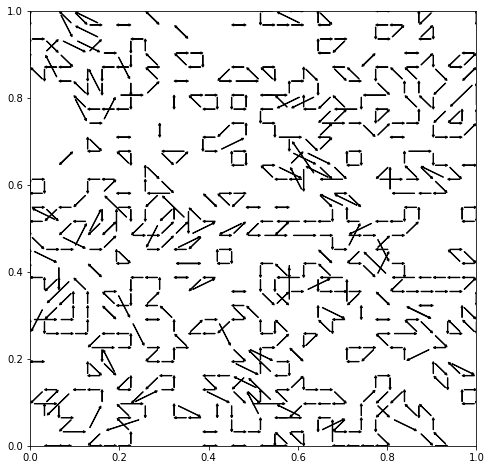

In [14]:
print "total iterations:", optimizer.lastState['iterations']

norm_grid_xy = optimizer.grid_norm
norm_optimized_grid_xy = norm_grid_xy[swapTable]
norm_xy = optimizer.xy_norm

plt.figure(figsize=(8, 8))
for start, end in zip(norm_xy, norm_optimized_grid_xy):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

plt.figure(figsize=(8, 8))
for end_rf, end_opt in zip(norm_grid_xy, norm_optimized_grid_xy):
    l = ( end_opt[0] - end_rf[0])*( end_opt[0] - end_rf[0]) + (end_opt[1] - end_rf[1])*(end_opt[1] - end_rf[1])
    if l > 0.0001:
        plt.arrow(end_rf[0] + (end_opt[0] - end_rf[0])*0.15, end_rf[1] + (end_opt[1] - end_rf[1])*0.15, (end_opt[0] - end_rf[0])*0.7, (end_opt[1] - end_rf[1])*0.7,
                  head_length=0.005, head_width=0.005, color='black')
    
plt.show()


As mentioned above you can even use the swap optimizer to find a near optimum solution for an entirely random arrangement. But you will have to give it enough iterations to do so. So let's shuffle the swap table first:

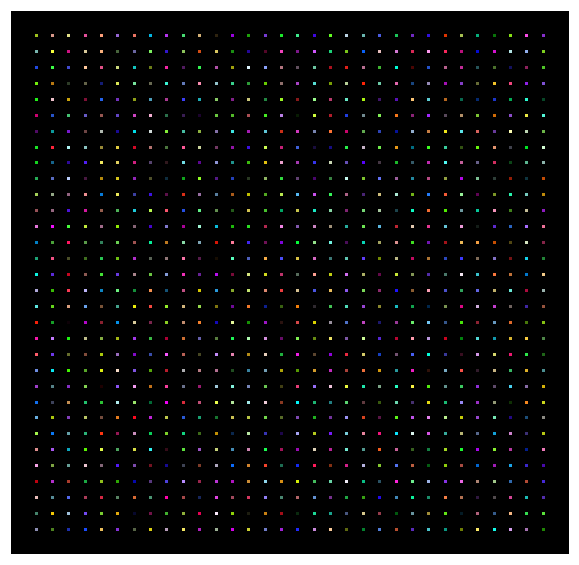

In [15]:
np.random.shuffle(swapTable)
shuffled_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(shuffled_xy[:,0],shuffled_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

In [16]:
iterations = 100000 #let first see how far 100.000 will get us
swapTable = optimizer.optimize(xy, grid_xy,width,height,iterations,swapTable=swapTable)

Starting sum of distances 320.777138103
80000 159.172828739
81000 158.289907942
82000 157.511077041
83000 156.496588104
84000 155.85266935
85000 154.888491077
86000 153.96722566
87000 153.154762282
88000 152.611557158
89000 151.840448525
90000 151.12273452
91000 149.977409238
92000 149.035625564
93000 148.461664538
94000 147.718060312
95000 147.088760453
96000 145.900573026
97000 145.176943245
98000 144.305705371
99000 143.651697433
final distance sum: 142.526579419
improvement: 178.250558684


After 100.000 iterations we can already see some order emerging:

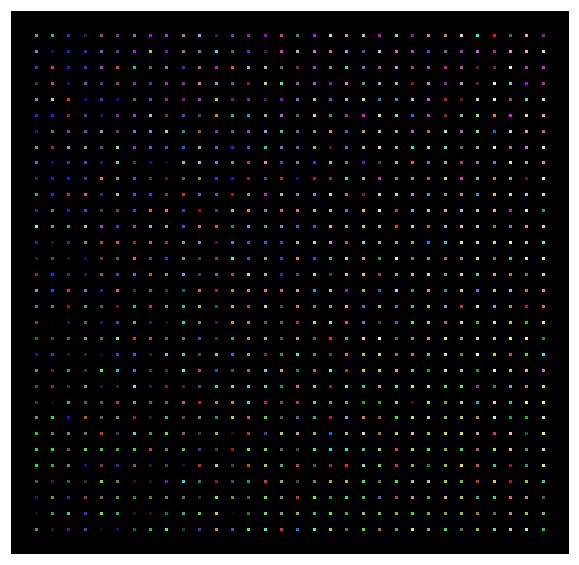

In [17]:
optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

Let's continue the process for another million iterations:

Starting sum of distances 142.526579419
980000 13.6190701248
981000 13.6175518868
982000 13.6123446502
983000 13.6121647686
984000 13.6121647686
985000 13.6121647686
986000 13.6121647686
987000 13.6085561247
988000 13.6085561247
989000 13.6081933651
990000 13.6068604602
991000 13.6065986341
992000 13.6065986341
993000 13.6065986341
994000 13.6065986341
995000 13.6044543794
996000 13.6012056764
997000 13.6001947278
998000 13.5989709368
999000 13.5989709368
final distance sum: 13.5989709368
improvement: 128.927608483


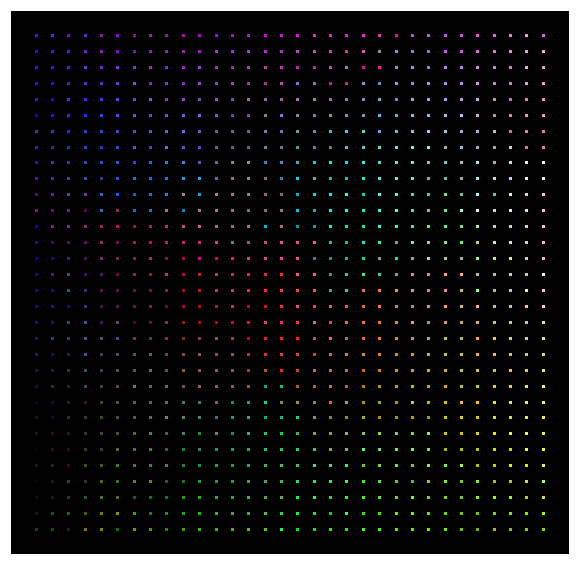

In [19]:
swapTable = optimizer.continueOptimization(1000000)

optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

What is interesting is that sometimes this shuffle approach generates a better solution than the best solution evolved from the original Raster Fairy arrangement (not in this run though). This is not totally surprising - the Raster Fairy solution could be seen as a very strong local optimum that is very hard to get out of whereas starting from the random state there are many more possible routes to get out of that fitness valley.

total iterations: 1600000


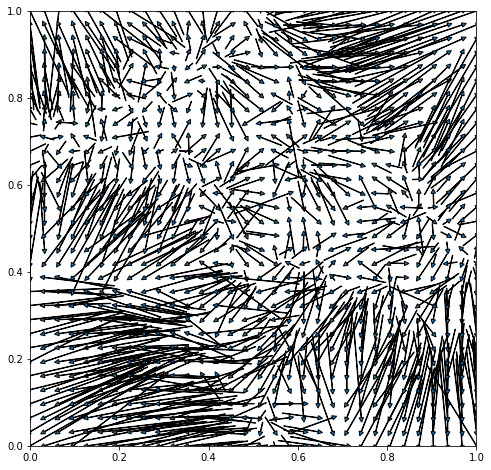

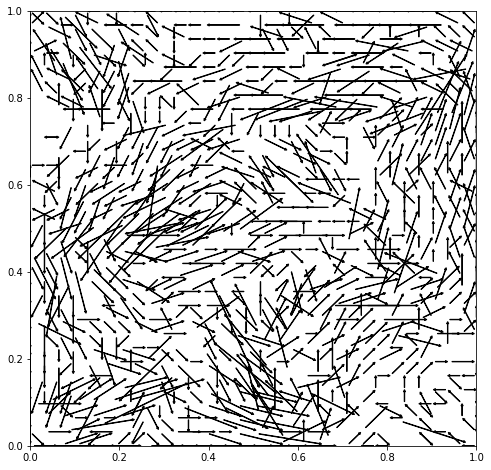

In [20]:
print "total iterations:", optimizer.lastState['iterations']

norm_grid_xy = optimizer.grid_norm
norm_optimized_grid_xy = norm_grid_xy[swapTable]
norm_xy = optimizer.xy_norm

plt.figure(figsize=(8, 8))
for start, end in zip(norm_xy, norm_optimized_grid_xy):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

plt.figure(figsize=(8, 8))
for end_rf, end_opt in zip(norm_grid_xy, norm_optimized_grid_xy):
    l = ( end_opt[0] - end_rf[0])*( end_opt[0] - end_rf[0]) + (end_opt[1] - end_rf[1])*(end_opt[1] - end_rf[1])
    if l > 0.0001:
        plt.arrow(end_rf[0] + (end_opt[0] - end_rf[0])*0.15, end_rf[1] + (end_opt[1] - end_rf[1])*0.15, (end_opt[0] - end_rf[0])*0.7, (end_opt[1] - end_rf[1])*0.7,
                  head_length=0.005, head_width=0.005, color='black')
    
plt.show()
